In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=4)
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [2]:
import torch.nn as nn
from torch import Tensor
from torch.optim import Optimizer
from torch.nn.modules.loss import _Loss
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
def display_image(ax,
    t: Tensor):
    n = t.detach().numpy()
    ax.imshow(n.reshape(28, 28))

def print_img(imgs:Tensor):
  t = imgs.detach().numpy()
  fig, ax = plt.subplots()
  ax.imshow(t.reshape(28, 28))



In [3]:
class Encoder(nn.Module):
  def __init__(self, hidden_dim: int = 28):
    super(Encoder, self).__init__()
    self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, hidden_dim, 7))
   
  def forward(self, x: Tensor) -> Tensor:
     x = self.conv1(x)
     return x

In [4]:
class Decoder(nn.Module):
  def __init__(self, hidden_dim: int = 28):
    super(Decoder, self).__init__()
    self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )         

  def forward(self, x: Tensor) -> Tensor:
    x = self.conv2(x)
    return x

In [5]:
class Autoencoders(nn.Module):


      def __init__(self, hidden_dim: int = 28):  
        super(Autoencoders, self).__init__()
        self.encoder = Encoder(hidden_dim)
        self.decoder = Decoder(hidden_dim)

      def forward(self, x: Tensor) -> Tensor:
        # Проход
        encoding = self.encoder(x)
        
        # Обратно идем
        x = self.decoder(encoding)
        return x

In [6]:
class TrainerAutoEncoder(object):

  def __init__(self, model, optim: Optimizer, criterion: _Loss):
        
        self.model = model
        self.optim = optim
        self.loss = criterion
  
  def fit(self, dataloader: DataLoader = None, num_epochs = 1):
    
    for epoch in range(num_epochs):
      for data in dataloader:
        
          # Batch_img (1)
          img, _ = data
          img = Variable(img).cpu()

          # ===================forward=====================
          output = self.model(img)
          loss = self.loss(output, img)
        
          # ===================backward====================
          self.optim.zero_grad()
          loss.backward()
          self.optim.step()

          # ===================log========================
      print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))



In [9]:
model = Autoencoders()
train = TrainerAutoEncoder(model, optim.SGD(model.parameters(), lr=0.01, momentum=0.9),nn.MSELoss())
train.fit(dataloader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch [1/1], loss:0.4083


In [7]:
def print_images_dataloader(model, dataloader, num = 10):
  cnt  = 0
  for data in dataloader:
    img, _ = data
    img = Variable(img).cpu()
    f, axarr = plt.subplots(1,2)
    display_image(axarr[0], img[0])
    display_image(axarr[1],model(img))
    
    axarr[0].set_title("Original image")
    axarr[1].set_title("Image reconstructed\nfrom autoencoder")
    
    axarr[0].axis('off')
    axarr[1].axis('off');
    latent = model.encoder(img)
    cnt += 1
    if (cnt == num):
      break


In [11]:
def print_transition_img_VAE(model, img1, img2, steps = 20):
  f, axarr = plt.subplots(1,2)
  display_image(axarr[0], img1[0])
  display_image(axarr[1], img2[0])
    
  axarr[0].set_title("Image")
  axarr[1].set_title("Image_To")
  
  enc_1 = model.encoder(img1)
  enc_2 = model.encoder(img2)

  """
  a * l + (1 - a) * l2
  """
  step = 1 / steps
  copy = enc_1
  for i in range(steps):
    copy = enc_1 * (i * step) + enc_2* (1 - i * step)
    imgs = model.decoder(copy)
    print_img(imgs)

In [8]:
def print_transition_img(model, img1, img2, steps = 20):
  f, axarr = plt.subplots(1,2)
  display_image(axarr[0], img1[0])
  display_image(axarr[1], img2[0])
    
  axarr[0].set_title("Image")
  axarr[1].set_title("Image_To")
  
  enc_1 = model.encoder(img1)
  enc_2 = model.encoder(img2)
  transit = enc_2 - enc_1
  step = transit / steps
  copy = enc_1
  for i in range(steps):
    copy = copy +  step
    imgs = model.decoder(copy)
    print_img(imgs)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


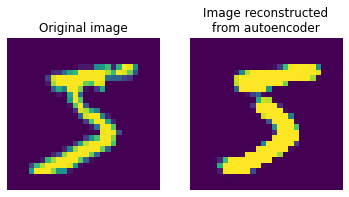

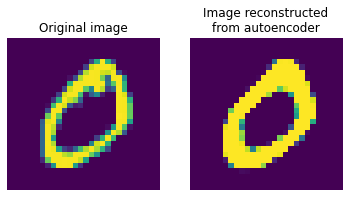

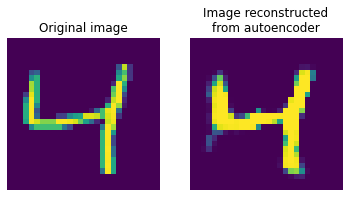

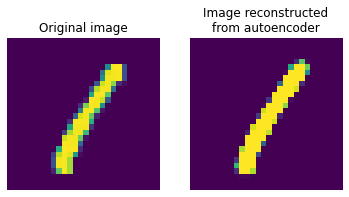

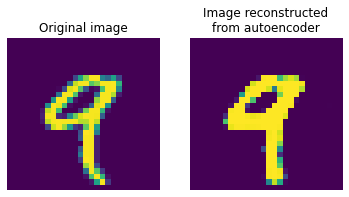

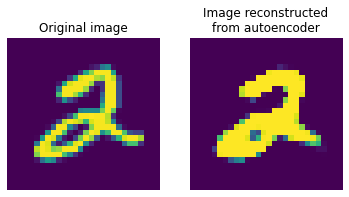

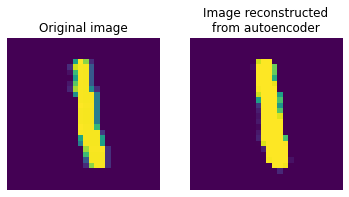

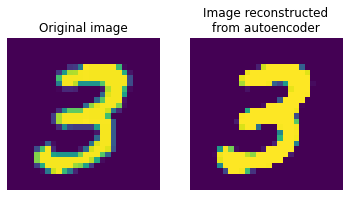

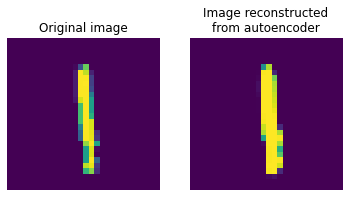

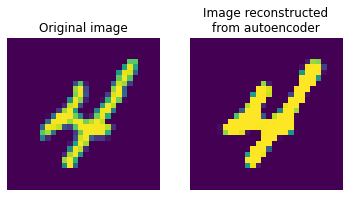

In [ ]:
print_images_dataloader(model,dataloader, 10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


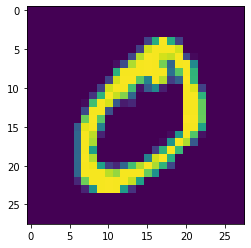

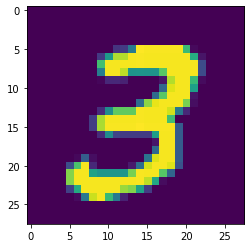

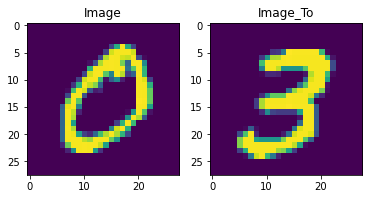

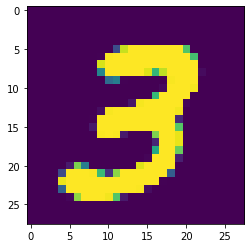

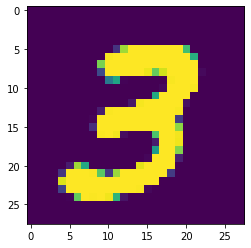

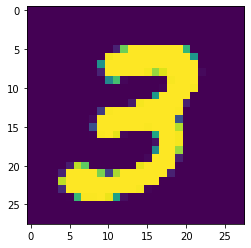

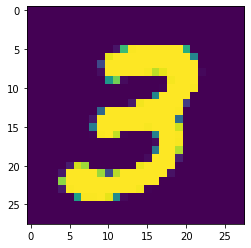

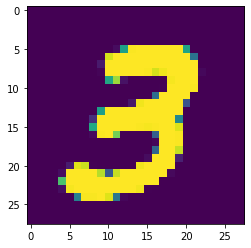

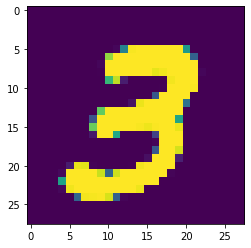

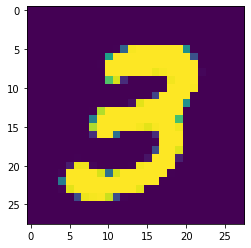

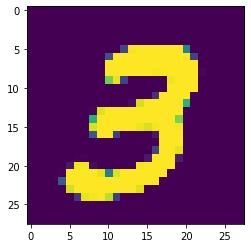

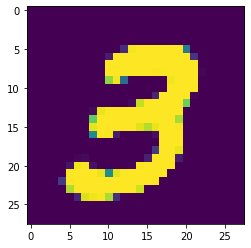

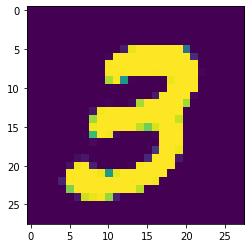

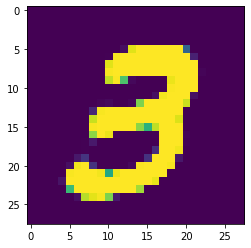

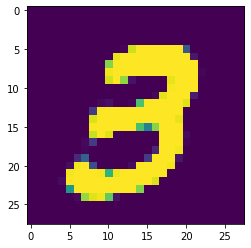

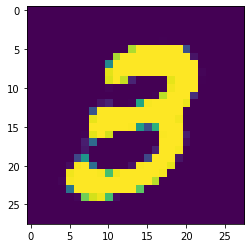

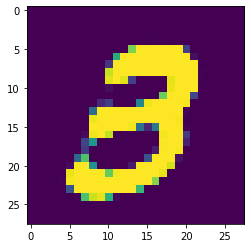

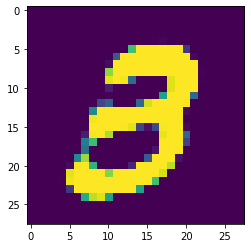

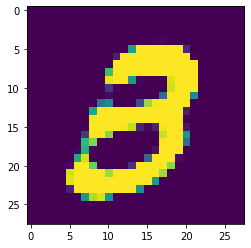

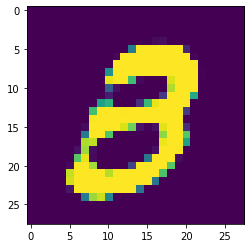

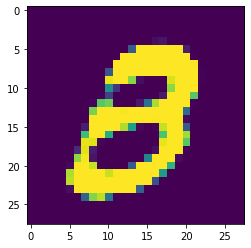

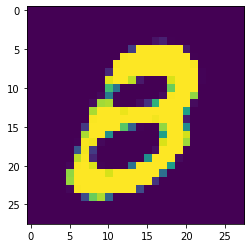

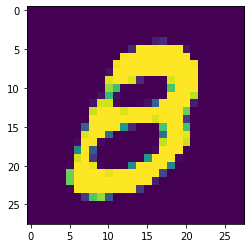

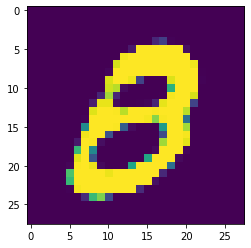

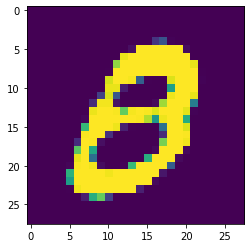

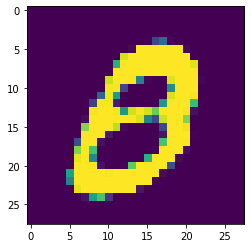

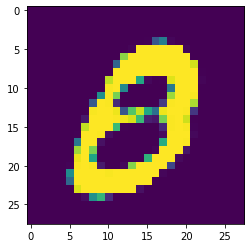

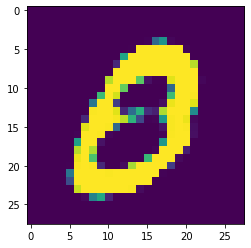

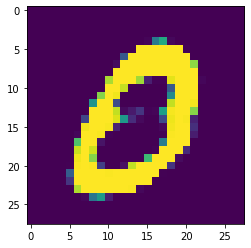

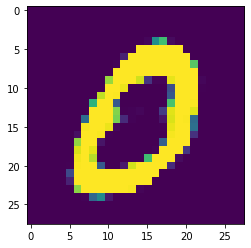

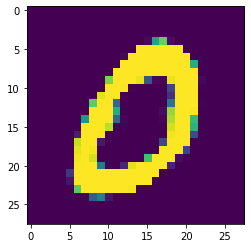

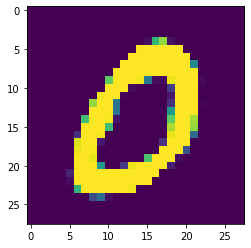

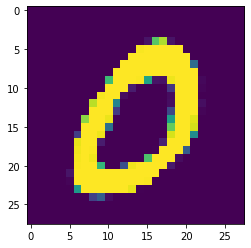

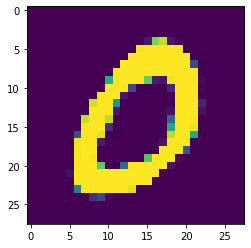

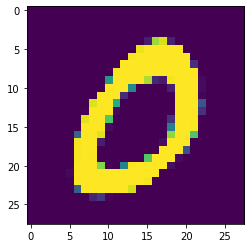

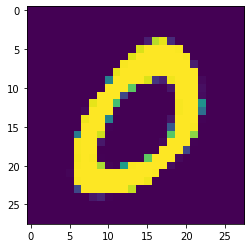

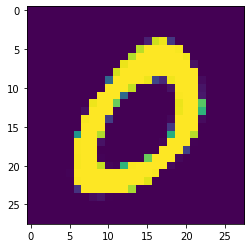

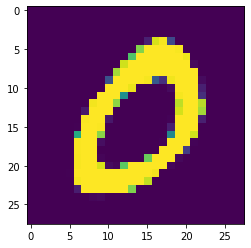

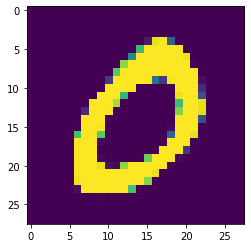

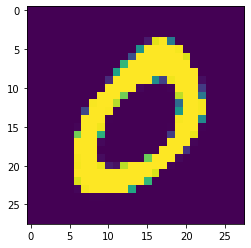

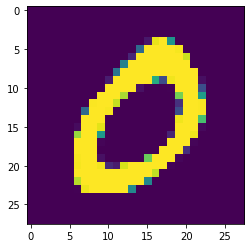

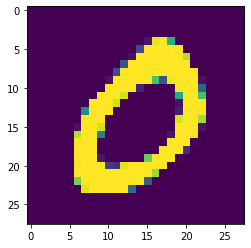

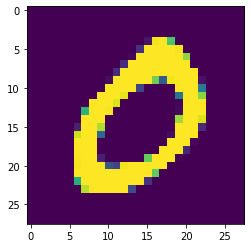

In [30]:
cnt = 0
one_num = 0
two_num = 0

for data in dataloader:
  # Batch_img (1)
  img, _ = data
  img = Variable(img).cpu()
  # ===================forward=====================
  #print(img[0])
  #print_img(img[0])
  if cnt == 1:
    one_num = img
    print_img(img[0])

  if cnt == 7:
    two_num = img
    print_img(img[0])  
  if cnt == 10:
    break
  cnt += 1
        

print_transition_img_VAE(model, one_num, two_num, 40)

In [ ]:
model_10 = Autoencoders(10)
train = TrainerAutoEncoder(model_10, optim.SGD(model_10.parameters(), lr=0.01, momentum=0.9),nn.MSELoss())
train.fit(dataloader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch [1/1], loss:0.4836


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


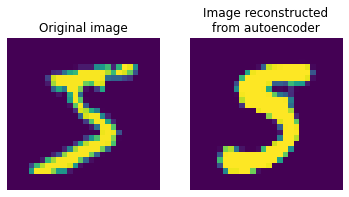

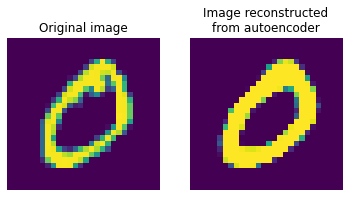

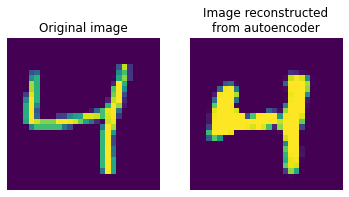

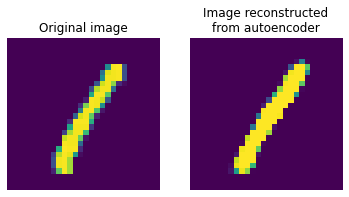

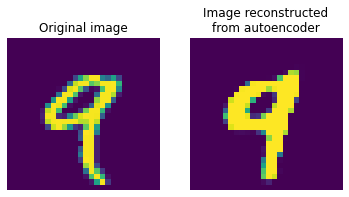

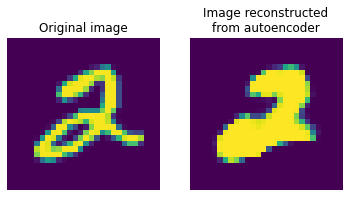

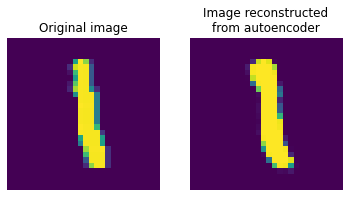

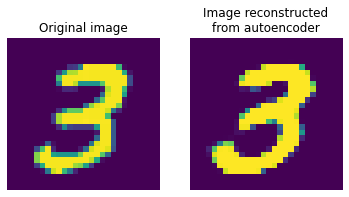

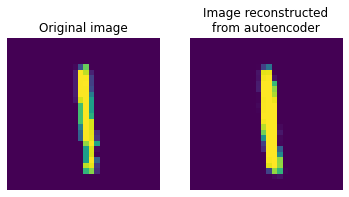

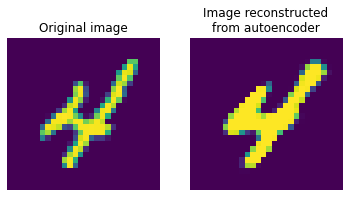

In [ ]:
print_images_dataloader(model_10, dataloader, 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


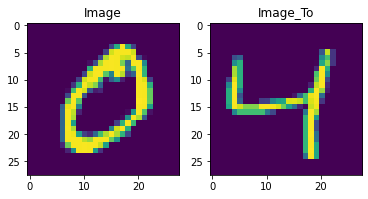

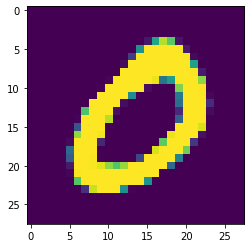

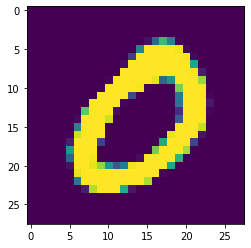

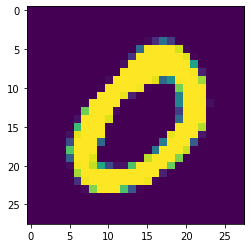

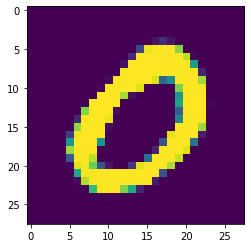

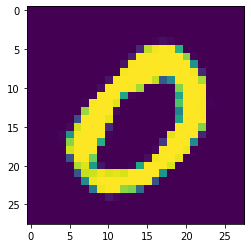

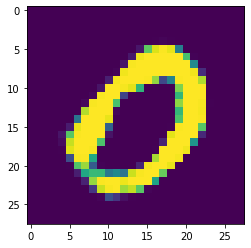

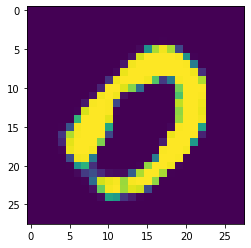

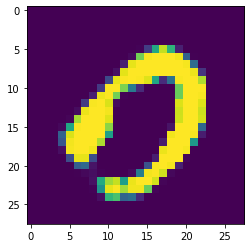

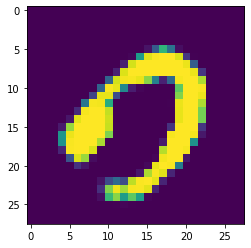

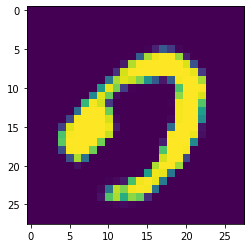

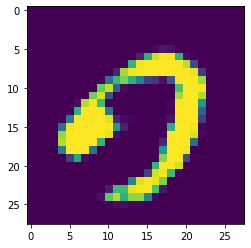

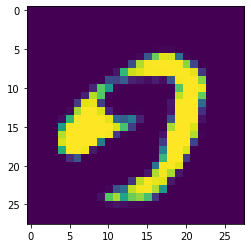

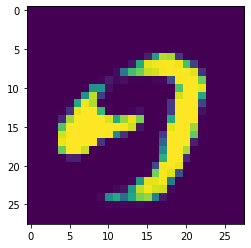

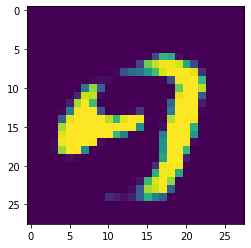

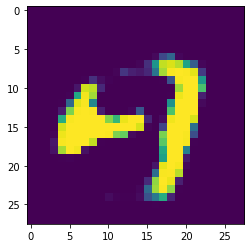

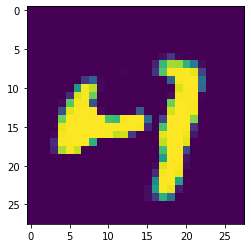

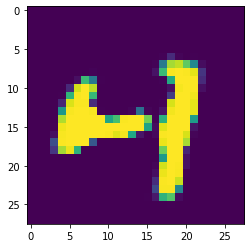

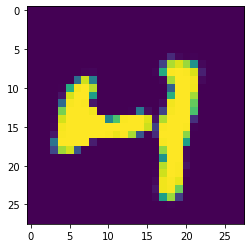

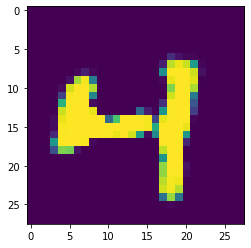

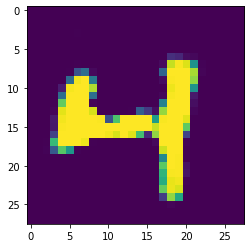

In [ ]:
print_transition_img(model_10, zero_, ones_)